# 🧪 MEMBRANE PREPARATION


In [ ]:
!pip install lipyphilic MDAnalysis netCDF4

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import MDAnalysis as mda
from lipyphilic.leaflets.assign_leaflets import AssignLeaflets
import lipyphilic as lpp
import numpy as np
import matplotlib.pyplot as plt
from lipyphilic.analysis.memb_thickness import MembThickness
from lipyphilic.analysis.z_thickness import ZThickness
from lipyphilic.analysis.flip_flop import FlipFlop
from MDAnalysis.analysis.leaflet import LeafletFinder

**Import and load the trajectory:**
Once `MDAnalysis` and `lipyphilic` are installed, we load the dynamics files (`.gro` and `.xtc`) as an MDAnalysis universe.
The variable `n_frames` represents the total number of frames in the trajectory, which helps keep track of how many frames are available for analysis.

In [ ]:
geom = "/content/drive/Shareddrives/Practicanato-Juli/Análisis/Membranas-asim/out-asim-small/martini_npt_303.gro"
traj = "/content/drive/Shareddrives/Practicanato-Juli/Análisis/Membranas-asim/out-asim-small/prod-Dome-40microseg-mol-c.xtc"

u = mda.Universe(geom , traj)
n_frames = len(u.trajectory)
total_time = u.trajectory.totaltime
print(f"Frames encontrados: {n_frames}")
print(f"Átomos por frame: {len(u.atoms)}")
print(f"Tiempo total de la dinámica (ps): {total_time}")

/usr/local/lib/python3.12/dist-packages/MDAnalysis/coordinates/XDR.py:253: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn(


Frames encontrados: 5887
Átomos por frame: 67993
Tiempo total de la dinámica: 5886000.0


**Assign leaflets:**
A *leaflet* corresponds to one monolayer of the bilayer. Each lipid must be assigned to its respective leaflet before any analysis is performed. Lipids are assigned based on the distance between their polar headgroups (GL1, GL2) and the bilayer midplane along the *z*-axis.

For membranes containing cholesterol, the optional argument `midplane_sel` can be used to define which residues are allowed near the bilayer midplane. The argument `midplane_cutoff` sets the maximum distance a residue can be from the midplane before it is considered unassigned to any leaflet.

Additionally, the `n_bins` parameter creates a 2D grid over the membrane to improve the spatial resolution of leaflet assignment. This is especially useful for undulating membranes (but not curved ones). Lipids are then assigned to either the upper or lower leaflet based on their distance from the local midplane of each grid cell.

In [ ]:

leaflets = lpp.AssignLeaflets(
  universe=u,
  lipid_sel="resname SAPE POPC CHOL SAPI and name GL1 GL2 ROH",
  midplane_sel="name ROH",
  midplane_cutoff=8, # unidades en A
  n_bins=10
)


leaflets.run(
  start=None,
  stop=None,
  step=10,
  verbose=True
)


  0%|          | 0/999 [00:00<?, ?it/s]

**Quick leaflet assignment check:**
Here we calculate the average number of lipids per frame assigned to each leaflet — the upper leaflet (1), the lower leaflet (-1), and in this case, since cholesterol is present, those assigned to the membrane midplane (0).

In [ ]:
L = leaflets.leaflets
print("shape:", L.shape)
print("valores únicos:", np.unique(L))
assert set(np.unique(L)).issubset({-1,0,1}), "Hay valores fuera de {-1,0,1}"

n_neg = np.sum(L == -1, axis=0)
n_pos = np.sum(L == 1, axis=0)
n_zero = np.sum(L == 0, axis=0)

print("Promedio por frame -> inferior(-1), superior(1), cero(0):",
      np.mean(n_neg), np.mean(n_pos), np.mean(n_zero))

shape: (1053, 999)
valores únicos: [-1  0  1]
Promedio por frame -> inferior(-1), superior(1), cero(0): 525.894894894895 522.7457457457457 4.35935935935936


# 📏 THICKNESS

**Start the membrane thickness calculation:**
We create the object `memb_thickness` using the `MembThickness` class. This class takes as input:
- the full MDAnalysis universe (`universe = MDAnalysis.Universe(gro, xtc)`),
- the leaflet assignment information (`leaflets.leaflets`), and
- the `filter_leaflets` parameter, which filters (keeps) only the specified lipid residues — useful for excluding cholesterol or focusing on specific lipids contributing to the bilayer thickness.

The argument `lipid_sel` is used to define which lipids and representative beads of the headgroups are selected.
Then, `memb_thickness.run()` executes the frame-by-frame thickness calculation.

The result is stored in the 1D array `memb_thickness.memb_thickness`, which contains the membrane thickness value for each frame.

Thickness can also be computed using spatial “bins” of a defined size (`n_bins`), allowing local thickness calculation across the membrane surface. By default, `MembThickness` computes the thickness over the entire XY area (a single bin).

In [ ]:
memb_thickness = MembThickness(
  universe=u,
  leaflets=leaflets.filter_leaflets("resname SAPE POPC SAPI"),
  lipid_sel="resname SAPE POPC SAPI and name PO4",
  n_bins=100,
  return_surface=True,
  interpolate=True
)

memb_thickness.run(
  start=None,
  stop=None,
  step=10,
  verbose=True,
)

  0%|          | 0/589 [00:00<?, ?it/s]

In [ ]:
# Promedio de todos los lipidos en todos los frames
mean_thickness = np.nanmean(memb_thickness.memb_thickness)

# Desviación estándar
std_thickness = np.nanstd(memb_thickness.memb_thickness)

print(f"Espesor de la membrana promedio: {mean_thickness:.3f} Å")
print(f"Desviación estándar: {std_thickness:.3f} Å")

Espesor de la membrana promedio: 41.377 Å
Desviación estándar: 0.251 Å


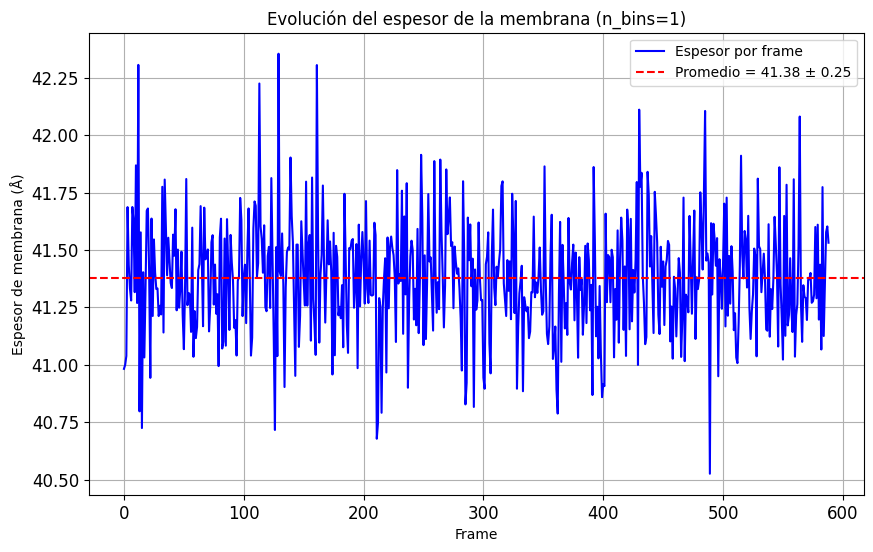

In [ ]:
thickness_values = memb_thickness.memb_thickness

frames = np.arange(len(thickness_values))

plt.figure(figsize=(10,6))
plt.plot(frames, thickness_values, label="Espesor por frame", color="blue")
plt.axhline(mean_thickness, color="red", linestyle="--",
            label=f"Promedio = {mean_thickness:.2f} ± {std_thickness:.2f}")

plt.xlabel("Frame")
plt.ylabel("Espesor de membrana (Å)")
plt.title("Evolución del espesor de la membrana (n_bins=1)")
plt.legend()
plt.grid(True)
plt.show()


# 💧 DENSITY PROFILE

**Density calculation along the Z-axis:**
A `.xvg` file generated with GROMACS contains the density values of predefined molecular groups as a function of the *z*-axis.
In this example, the defined groups are: Water, Sugars (SAPI), Phosphate groups, Lipid tails, Ions, Glycerol, and Cholesterol.

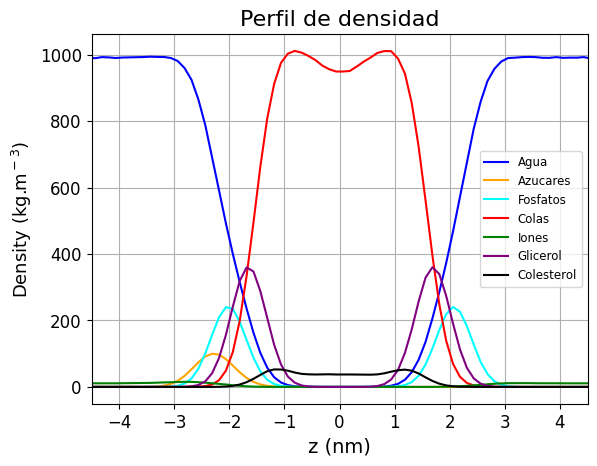

In [ ]:
data2 = np.loadtxt("/content/drive/Shareddrives/Practicanato-Juli/Análisis/Membranas-asim/out-asim-small/density-out-asim-small-tmp.xvg", comments=["#", "@"])
colors = ('blue','orange','cyan','red','green','purple','black')
labels = ('Agua','Azucares','Fosfatos','Colas','Iones','Glicerol','Colesterol')
for i in range(1,8):
    plt.plot((data2[:,0]), data2[:,i], color=colors[i-1], label=labels[i-1])

plt.legend(fontsize=8.5)
plt.title('Perfil de densidad', fontsize=16, color = 'black')
plt.xlabel('z (nm)', fontsize=14)
plt.ylabel('Density (kg.m$^-$$^3$)', fontsize=13)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
#plt.ylim(-2,400)
plt.xlim(-4.5,4.5)
plt.grid()
#plt.savefig('/content/drive/Shareddrives/Practicanato-Juli/Análisis/Membranas-asim/out-asim-small/Perfil-density.png', dpi=600, bbox_inches="tight")
plt.show()

**Calculate the distance between the phosphate density peaks:**
From the phosphate density profiles, we can estimate the bilayer thickness by calculating the distance between the two phosphate peaks along the *z*-axis.

In [ ]:
phosphates = data2[:, 3]
z_positions = data2[:, 0]

top2_idx = np.argsort(phosphates)[-2:]  # devuelve los índices de los 2 mayores valores

# Ordenarlos de mayor a menor
top2_idx = top2_idx[np.argsort(phosphates[top2_idx])[::-1]]

# Extraer valores de densidad y posiciones en z
top2_densities = phosphates[top2_idx]
top2_z = z_positions[top2_idx]

distancia = abs((top2_z[0] - top2_z[1])*10)

print(f"Distancia entre los dos máximos = {distancia:.4f} Å")

Distancia entre los dos máximos = 41.2128 Å
